# Vyacheslav Stepanyan | HW3 | DS235

# Part 1: Building a Tokenizer for Armenian Language

[Byte-Pair Encoding tokenization](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt) from Hugging Face NLP course can be helpful for completing this part.

Tokenization plays a very important role in language modelling. It is one of the earliest methods designed to teach computers how to understand human language.

Naturally, computers do not understand human language. In order to be able to process text, we use tokenization to break large texts into smaller, more manageable units. These smaller pieces can then be parsed by an algorithm or fed into a neural network to solve various tasks. These tokens can be individual characters, words or subword units, depending on what kind of task we want to solve.

An overview of tokenization pipeline is demonstrated below

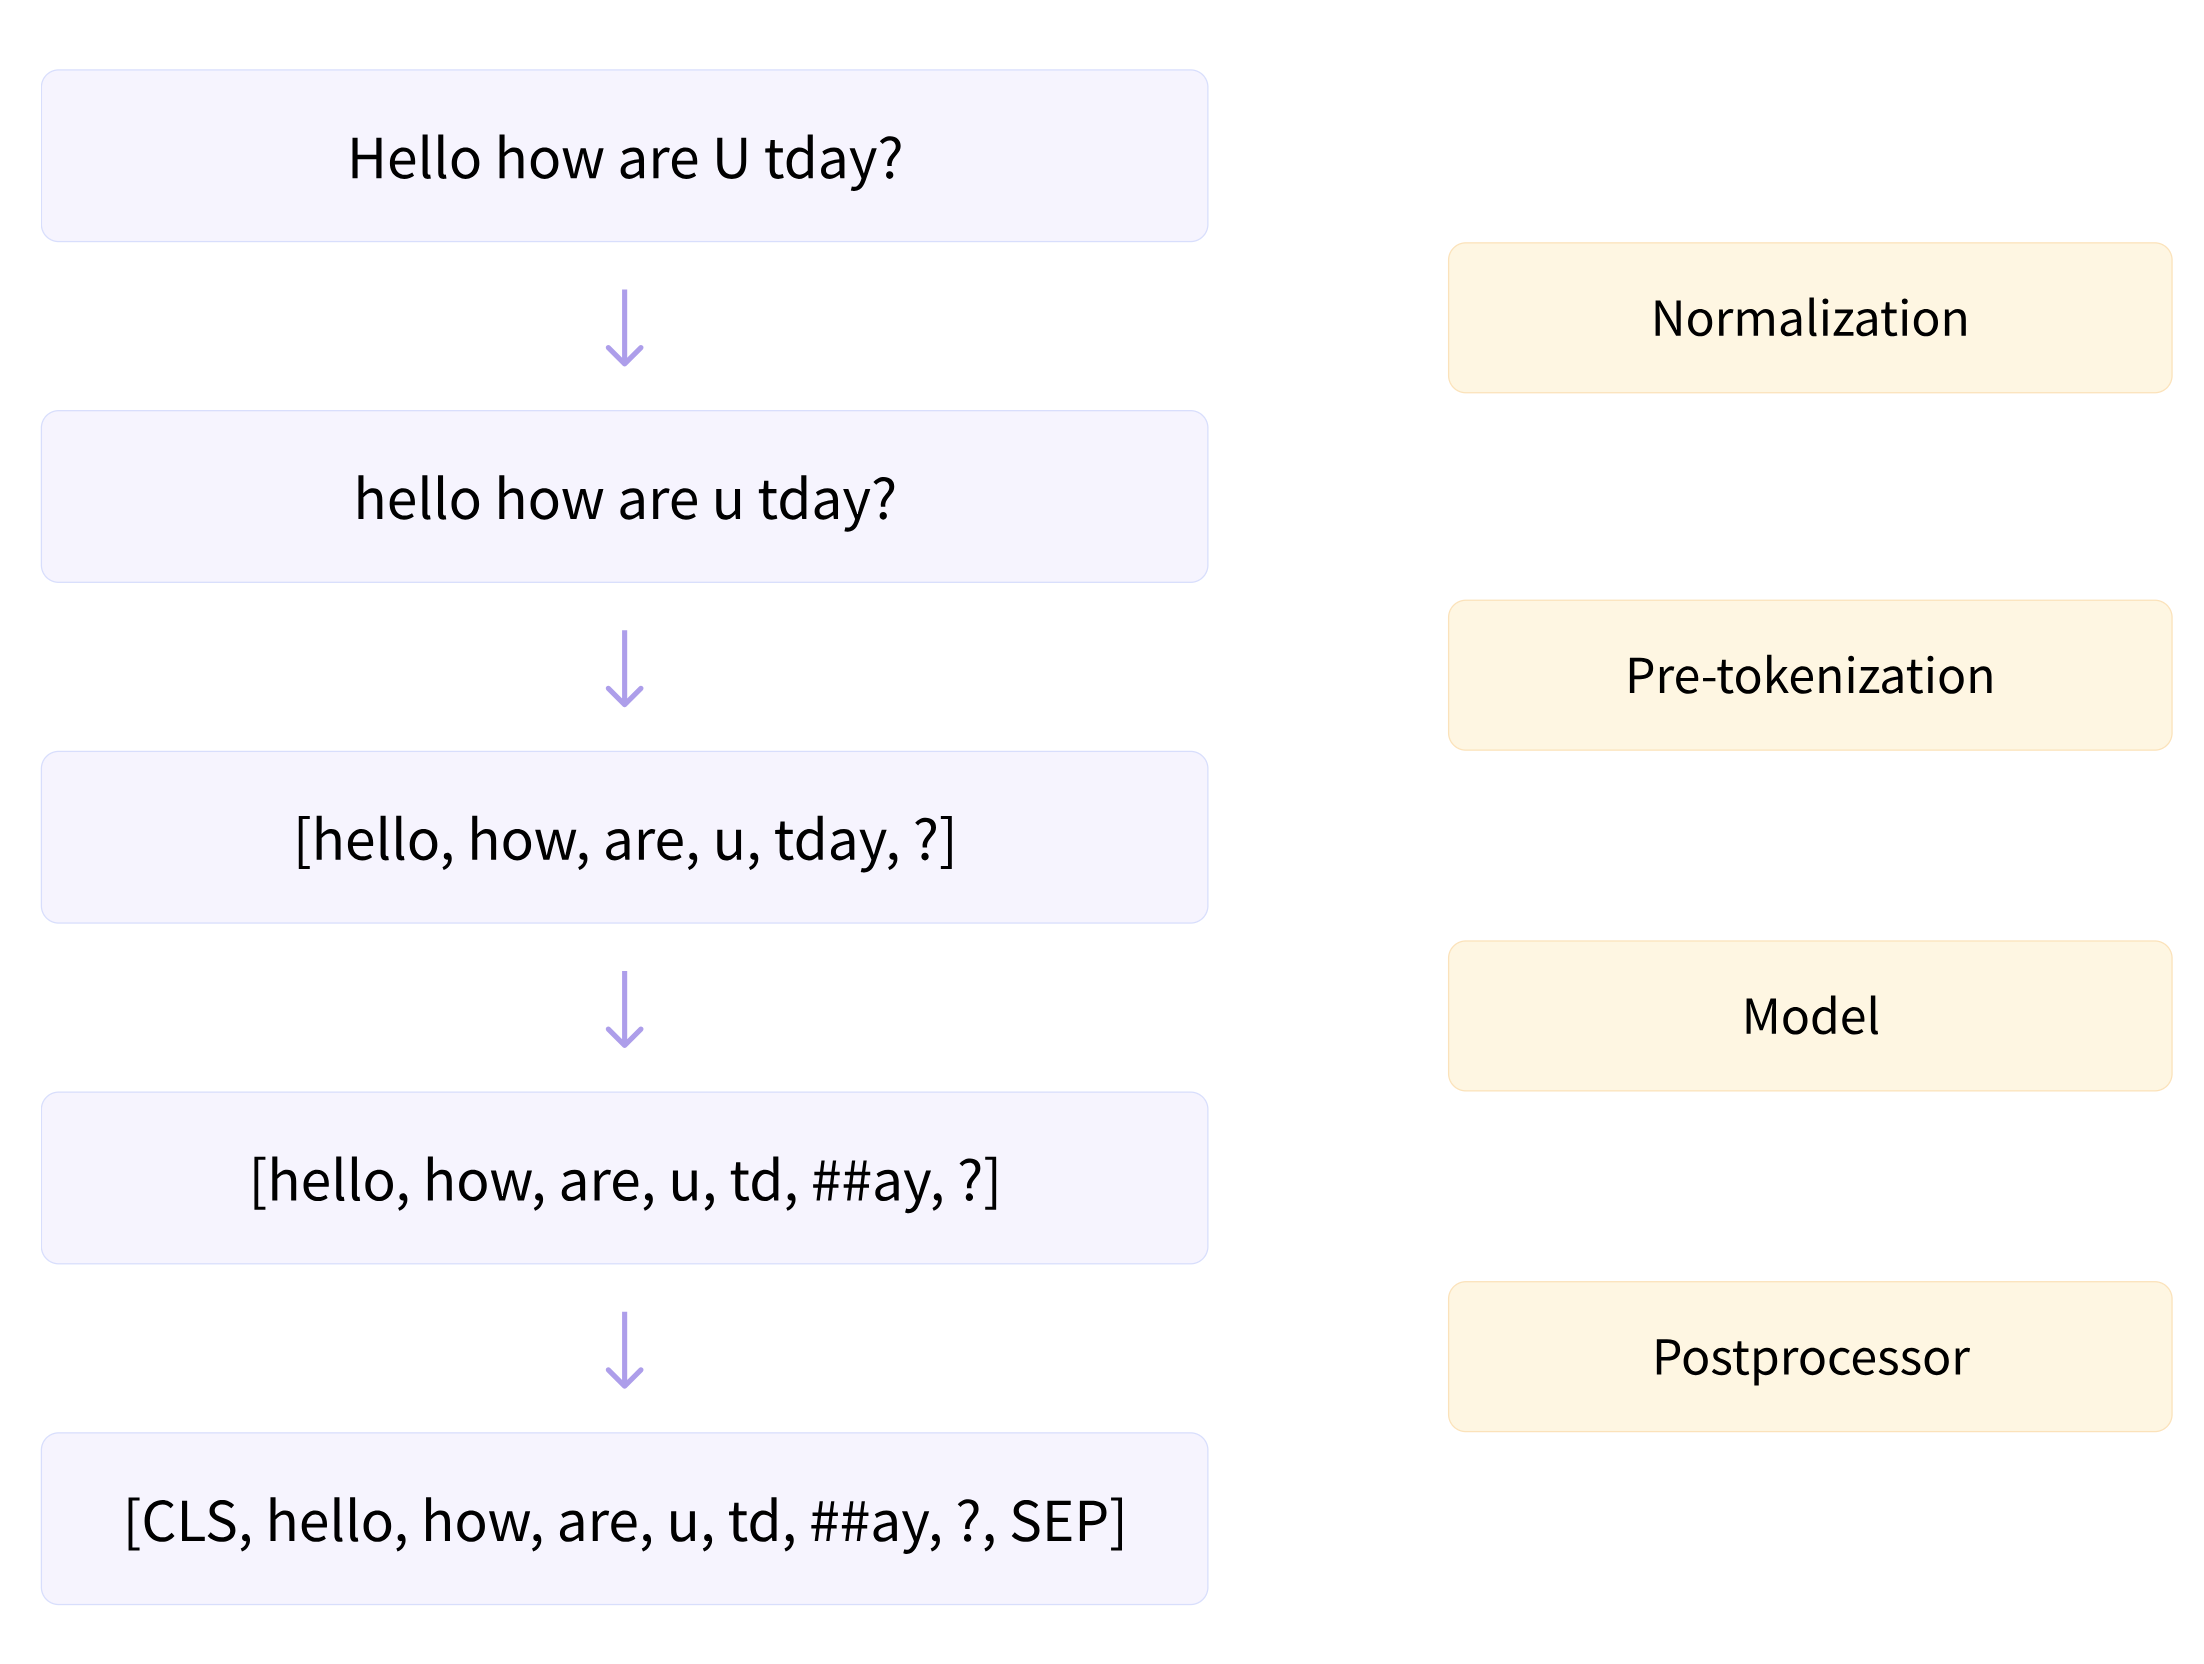

Install a package for handling regex. Python already has an inbuilt regex package, but the `regex` package supports nice additional functionality that allows easier handling of text splitting.

In [1]:
!pip3 install regex

## Byte Pair Encoding (BPE)

We will be implementing the BPE algorithm for subword tokenization. BPE is a common algorithm that is used in modern LLMs. BPE breaks down words into smaller sub-word pieces which are then handled by the language model.  

The idea behind BPE is to find the most frequently occurring pair of characters in a text and merge them into a new token. By repeating this process, BPE creates a dictionary of most common subword units. Thus, it learns to break down text into commonly used sub units. BPE is a method which stands in between character-level tokenization and word level tokenization.  

Character level tokenization breaks down the text into individual characters. Word level tokenization uses every word as a token. In contrast, BPE uses subword units. As a result, it has the ability to handle unknown words (by breaking them down). Also it has a reduced vocabulary size compared to word-level tokenization since similar words are broken down into common subwords instead of being treated as a separate token.

# Step 1: Reading in the Data

Read the text data in the file `data.txt` into the corpus variable. It contains Armenian text which we will be using to build our BPE tokenizer.

In [2]:
corpus = None

# YOUR CODE GOES HERE
with open('data.txt', 'r', encoding='utf-8') as f: # I have specified the encoding as it is needed for windows to read this file
    corpus = f.read()


print(corpus)

ՔԱՋ ՆԱԶԱՐԸ

1

Լինում է, չի լինում՝ մի խեղճ մարդ, անունը՝ Նազար։ Էս Նազարը մի անշնորհք ու ալարկոտ մարդ է լինում․ է՜նքան էլ վախկոտ, է՜նքան էլ վախկոտ, որ մենակ ոտը ոտի առաջ չէր դնիլ, թեկուզ սպանեիր։ Օրը մինչև իրիկուն կնկա կողքը կտրած՝ նրա հետ դուրս գնալիս դուրս էր գնում, տուն գալիս՝ տուն գալի։ Դրա համար էլ անունը դնում են Վախկոտ Նազար։

Էս Վախկոտ Նազարը մի գիշեր կնկա հետ շեմքն է դուրս գալի։ Որ շեմքն է դուրս գալի, տեսնում է ճրըքճրըքան լո՜ւս—լուսնյակ գիշեր, ասում է․

— Ա՛յ կնիկ, ի՜նչ քարվան կտրելու գիշեր է՜․․․ Սիրտս ասում է՝ վեր կաց գնա Հնդստանից եկող Շահի քարվանը կտրի, բեր տունը լցրու․․․

Կնիկը թե՝

— Ձենդ կտրի, տեղդ նստի, քարվան կտրողիս մտիկ արա․․․։

Նազարը թե՝

— Անզգա՛մ կնիկ, ինչո՞ւ չես թող անում՝ ես գնամ քարվան կտրեմ, բերեմ տունը լցնեմ։ Էլ ի՞նչ տղամարդ եմ ես, էլ ինչո՞ւ եմ գդակ ծածկում, որ դու համարձակվում ես իմ առաջը խոսես։

Որ շատ կռվում է, կնիկը տուն է մտնում, դուռը փակում։

— Հո՛ղեմ էդ վախկոտ գլուխդ, դե հիմի գնա քարվան կտրի։ ﻿Էս Նազարս մնում է դռանը։ Վախից լեղապատառ է լինում։ Ինչքա

# Step 2: Pre-Splitting and Counting

Split the entire text into groups using the defined regex pattern. Use `findall` function to perform the split. Then, count the number of unique chunks and insert them in the chunk_freqs dict. The dict should contain **chunk -> freq pairs**.  

This count will later be used to count the number of pairs for BPE merging.

Note: We could avoid counting number of chunks but that would be less efficient as we would have to count the number of pairs on the whole list of chunks, instead of unique chunks.

Those who are curious about further optimization can read here: https://guillaume-be.github.io/2021-09-16/byte_pair_encoding

We will implement BPE with pre-splitting. By splitting initial text into chunks, we will control what kinds of tokens can and cannot be merged together.
This is done to prevent cross merging of text and whitespace or text with punctuation. Thus, semantics of the text will be preserved and no meaningless tokens will be created.

We will pre-split the text using a regex pattern

In [3]:
import regex as re

corpus = re.sub(r'\n+', r'\n', corpus) # Replace repeated new lines with just a single new line character.

# This pattern is used for pre-splitting in GPT4. Its pretty elaborate.
pattern = re.compile(r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+""")

In [4]:
# Demonstration of how the pattern works. Notice how each word that is not in the beginning of the sentence has a space in front.
print(re.findall(pattern, "This is some text. Here are numbers 345 44556. Punctuation: , . :"))

['This', ' is', ' some', ' text', '.', ' Here', ' are', ' numbers', ' ', '345', ' ', '445', '56', '.', ' Punctuation', ':', ' ,', ' .', ' :']


In [5]:
# Count the frequency of each chunk in the whole corpus.
# Insert the results in chunk_freqs dictionary. The key should be the chunk with value being the count.

from collections import defaultdict

chunk_freqs = defaultdict(int)

### YOUR CODE GOES HERE
chunks = re.findall(pattern, corpus)
for chunk in chunks:
    chunk_freqs[chunk] += 1

print(chunk_freqs)

defaultdict(<class 'int'>, {'ՔԱՋ': 1, ' ՆԱԶԱՐԸ': 1, '\n': 10, '1': 1, 'Լինում': 1, ' է': 188, ',': 281, ' չի': 14, ' լինում': 6, '՝': 71, ' մի': 44, ' խեղճ': 1, ' մարդ': 6, ' անունը': 6, ' Նազար': 18, '։': 78, ' Էս': 6, ' Նազարը': 21, ' անշնորհք': 1, ' ու': 56, ' ալարկոտ': 2, '․': 16, '՜նքան': 2, ' էլ': 48, ' վախկոտ': 3, ' որ': 42, ' մենակ': 4, ' ոտը': 2, ' ոտի': 3, ' առաջ': 3, ' չէր': 1, ' դնիլ': 1, ' թեկուզ': 1, ' սպանեիր': 1, ' Օրը': 1, ' մինչև': 7, ' իրիկուն': 1, ' կնկա': 3, ' կողքը': 1, ' կտրած': 2, ' նրա': 5, ' հետ': 4, ' դուրս': 12, ' գնալիս': 1, ' էր': 16, ' գնում': 14, ' տուն': 4, ' գալիս': 9, ' գալի': 13, ' Դրա': 1, ' համար': 3, ' դնում': 3, ' են': 72, ' Վախկոտ': 2, '։\n': 56, 'Էս': 6, ' գիշեր': 4, ' շեմքն': 2, ' Որ': 4, ' տեսնում': 12, ' ճրըքճրըքան': 1, ' լո': 1, '՜ւս': 1, '—լուսնյակ': 1, ' ասում': 10, '․\n': 6, '—': 20, ' Ա': 2, '՛յ': 4, ' կնիկ': 2, ' ի': 13, '՜նչ': 4, ' քարվան': 4, ' կտրելու': 1, '՜․․․': 2, ' Սիրտս': 1, ' վեր': 11, ' կաց': 1, ' գնա': 10, ' Հնդստանից': 1, '

# Step 3: Construct the initial vocab

In [6]:
%%time
# Define the initial vocab. It should contain all individual characters that are present in the corpus.

vocab = []

### YOUR CODE GOES HERE
vocab = list(set(corpus))
            
vocab.sort()
print(vocab)

['\n', ' ', ',', '-', '1', '2', '3', '4', '5', '6', '«', '»', 'Ա', 'Բ', 'Գ', 'Դ', 'Ե', 'Զ', 'Է', 'Ը', 'Թ', 'Ժ', 'Ի', 'Լ', 'Խ', 'Ծ', 'Կ', 'Հ', 'Ձ', 'Ճ', 'Մ', 'Ն', 'Շ', 'Ո', 'Պ', 'Ջ', 'Ս', 'Վ', 'Տ', 'Ր', 'Փ', 'Ք', 'Օ', '՛', '՜', '՝', '՞', 'ա', 'բ', 'գ', 'դ', 'ե', 'զ', 'է', 'ը', 'թ', 'ժ', 'ի', 'լ', 'խ', 'ծ', 'կ', 'հ', 'ձ', 'ղ', 'ճ', 'մ', 'յ', 'ն', 'շ', 'ո', 'չ', 'պ', 'ջ', 'ռ', 'ս', 'վ', 'տ', 'ր', 'ց', 'ւ', 'փ', 'ք', 'օ', 'ֆ', 'և', '։', '֊', '–', '—', '․', '\ufeff']
CPU times: total: 0 ns
Wall time: 1 ms


In [7]:
# Our initial vocabulary will contain the pieces + the end of text token. We will extend it by iteratively merging together most common pair of elements
vocab = ["<|endoftext|>"] + vocab

# Step 4: Split text chunks into individual characters for BPE

In [8]:
# Generate the initial splits for each chunk.

# Before training the tokenizer, each chunk should be split character by character.
# Then, after merging a common pair of tokens, splits of chunks should be updated to have the merged token.

### YOUR CODE GOES HERE
splits = defaultdict(list)
for chunk in chunks:
    splits[chunk] = [*chunk]

# Splits should be dict with chunks as keys and splits as values
# Example: 'Լինում': ['Լ', 'ի', 'ն', 'ո', 'ւ', 'մ']
# After merging most common pairs, these splits will be changed as well



print(splits)

defaultdict(<class 'list'>, {'ՔԱՋ': ['Ք', 'Ա', 'Ջ'], ' ՆԱԶԱՐԸ': [' ', 'Ն', 'Ա', 'Զ', 'Ա', 'Ր', 'Ը'], '\n': ['\n'], '1': ['1'], 'Լինում': ['Լ', 'ի', 'ն', 'ո', 'ւ', 'մ'], ' է': [' ', 'է'], ',': [','], ' չի': [' ', 'չ', 'ի'], ' լինում': [' ', 'լ', 'ի', 'ն', 'ո', 'ւ', 'մ'], '՝': ['՝'], ' մի': [' ', 'մ', 'ի'], ' խեղճ': [' ', 'խ', 'ե', 'ղ', 'ճ'], ' մարդ': [' ', 'մ', 'ա', 'ր', 'դ'], ' անունը': [' ', 'ա', 'ն', 'ո', 'ւ', 'ն', 'ը'], ' Նազար': [' ', 'Ն', 'ա', 'զ', 'ա', 'ր'], '։': ['։'], ' Էս': [' ', 'Է', 'ս'], ' Նազարը': [' ', 'Ն', 'ա', 'զ', 'ա', 'ր', 'ը'], ' անշնորհք': [' ', 'ա', 'ն', 'շ', 'ն', 'ո', 'ր', 'հ', 'ք'], ' ու': [' ', 'ո', 'ւ'], ' ալարկոտ': [' ', 'ա', 'լ', 'ա', 'ր', 'կ', 'ո', 'տ'], '․': ['․'], '՜նքան': ['՜', 'ն', 'ք', 'ա', 'ն'], ' էլ': [' ', 'է', 'լ'], ' վախկոտ': [' ', 'վ', 'ա', 'խ', 'կ', 'ո', 'տ'], ' որ': [' ', 'ո', 'ր'], ' մենակ': [' ', 'մ', 'ե', 'ն', 'ա', 'կ'], ' ոտը': [' ', 'ո', 'տ', 'ը'], ' ոտի': [' ', 'ո', 'տ', 'ի'], ' առաջ': [' ', 'ա', 'ռ', 'ա', 'ջ'], ' չէր': [' ', 'չ', 'է', 'ր'

# Step 5: Create a function to compute frequencies of pairs

In [9]:
# Write a function that counts the frequencies of pairs of tokens in all chunks. After this, the pair that occurs most often will be merged into a new token
# This way, the tokenizer learns to merge smaller units into more meaningful subword units.

def compute_pair_freqs(splits):
    """
    Arguments
    splits: dict. A dictionary of chunks and their splits:
    {
        'Լինում': ['Լ', 'ի', 'ն', 'ո', 'ւ', 'մ']
    }

    Returns:
    pair_freqs: dict. A dictionary of pairs of tokens and their frequency
    {
        ('ո', 'ւ'): 10
    }
    """

    # pair_freqs should contain keys as pairs, and values as their frequency. Example ('a', 'b') -> 10
    pair_freqs = defaultdict(int)
    for chunk, freq in chunk_freqs.items():

        ### YOUR CODE GOES HERE
        split = splits[chunk]
        if len(split) == 1:
            continue
        pairs = [(splits[chunk][i],splits[chunk][i+1]) for i in range(len(splits[chunk])-1)]
        for pair in pairs:
            pair_freqs[pair] += freq
            
        
        
    return pair_freqs

In [10]:
pair_freqs = compute_pair_freqs(splits)

for i, key in enumerate(pair_freqs.keys()):
    print(f"{key}: {pair_freqs[key]}")
    if i >= 5:
        break

('Ք', 'Ա'): 1
('Ա', 'Ջ'): 1
(' ', 'Ն'): 62
('Ն', 'Ա'): 1
('Ա', 'Զ'): 1
('Զ', 'Ա'): 1


# Step 6: Find the most common pair

In [11]:
# Find the most occurring pair of tokens

best_pair = ""
max_freq = None

### YOUR CODE GOES HERE
best_pair = max(pair_freqs, key=pair_freqs.get)
max_freq = pair_freqs[best_pair]

print(best_pair, max_freq)

('ո', 'ւ') 524


# Step 7: Merge the most occurring pair

After finding the most common pair, we need to merge them and create a new token.

In [12]:
# Write a function that will merge most occurring pair of tokens into a new token for each chunk split
# Example: Lets say we need to merge 'a' and 'b' together. Our chunk splits is ('a', 'b', 'c'). It needs to become ('ab', 'c')

def merge_pair(a, b, splits):
    """
    a: 1st token
    b: 2nd token
    splits: dictionary of chunks and their splits:
    {
        'Լինում': ['Լ', 'ի', 'ն', 'ո', 'ւ', 'մ']
    }
    """
    for chunk in chunk_freqs:
        split = splits[chunk]

        ### YOUR CODE GOES HERE
        i=0
        while i < len(split)-1:
            if (split[i] == a) and (split[i+1] == b):
                split[i] = split[i] + split[i+1]
                del split[i+1]
            else:
                i+=1
        splits[chunk] = split
        
    return splits

# Step 8: Iterating. Keep finding the most common pair, then merging it. Add the merged token to the merges and vocab.

In [14]:
# Putting it all together. Use the code you wrote above to complete this section

# merges is dictionary that holds our learned merge rules. The key is the pair of tokens and value is their merge
# Example: ('ո', 'ւ'): ու
# This dictionary will be used to tokenize new texts. Pairs of tokens in the new text will be merged according to these rules.
merges = {}

# Number of times to find and merge most common pair of tokens
# More merges will result in larger subword units
# Less merges will result in smaller, almost character-level units
# This is a parameter that needs to be tuned per use-case. Experiment with it and find out what the results are for low or high numbers

num_merges = 250

for i in range(num_merges):
    ### YOUR CODE GOES HERE

    ### Count frequencies of each pair of tokens
    pair_freqs = compute_pair_freqs(splits)

    ### Find the most common pair of tokens
    a,b = max(pair_freqs, key=pair_freqs.get)

    ### Merge the most common pair into a new token
    splits = merge_pair(a,b,splits)
    ### Add the merge to the merges dictionary
    merges[(a,b)] = a+b

    ### Append the new token to our vocabulary
    vocab.append(a+b)

In [15]:
print(merges)

{('ո', 'ւ'): 'ու', (' ', 'է'): ' է', ('ա', 'ր'): 'ար', ('ու', 'մ'): 'ում', ('ա', 'ն'): 'ան', ('ե', 'ր'): 'եր', ('ե', 'ն'): 'են', ('ի', 'ն'): 'ին', (' ', 'մ'): ' մ', (' ', 'հ'): ' հ', ('ո', 'ր'): 'որ', (' ', 'կ'): ' կ', (' ', 'ա'): ' ա', (' ', 'գ'): ' գ', ('ա', 'զ'): 'ազ', ('ն', 'ում'): 'նում', (' ', 'տ'): ' տ', (' ', 'են'): ' են', ('ազ', 'ար'): 'ազար', (' ', 'ու'): ' ու', ('ի', 'ր'): 'իր', ('ե', 'ս'): 'ես', (' ', 'թ'): ' թ', ('Ն', 'ազար'): 'Նազար', (' ', 'վ'): ' վ', ('ա', 'կ'): 'ակ', ('։', '\n'): '։\n', ('ա', 'ծ'): 'ած', (' ', 'Նազար'): ' Նազար', ('ե', 'լ'): 'ել', ('ո', 'վ'): 'ով', ('ա', 'ջ'): 'աջ', (' ', 'դ'): ' դ', (' ', 'ս'): ' ս', (' ', 'ք'): ' ք', (' մ', 'ի'): ' մի', ('ու', 'ն'): 'ուն', ('ա', 'լ'): 'ալ', (' է', 'լ'): ' էլ', ('․', '․'): '․․', (' ', 'որ'): ' որ', (' ', 'բ'): ' բ', (',', '\n'): ',\n', (' ', 'իր'): ' իր', (' ', 'զ'): ' զ', ('ա', 'տ'): 'ատ', ('ի', 'ց'): 'ից', ('ա', 'ռ'): 'առ', (' ', 'ն'): ' ն', ('ա', 'մ'): 'ամ', (' ', 'ան'): ' ան', ('ա', 'գ'): 'ագ', ('ա', 'վ'): 'ավ', (

# Final Step: Tokenization. Write a function that takes text and tokenizes it based on the merges and vocabulary learned above

In [16]:
# First, split the sentence into chunks using the regex pattern.
# Then generate initial splits of chunks into individual characters.
# After this, look up which pairs of characters can be merged in the merges dictionary.
# If characters can be merged, merge them together.

def tokenize(text):
    """
    Arguments:
    text: str. The text to tokenize

    Returns:
    A list of tokens that comprise the given text
    """

    ### YOUR CODE GOES HERE
    chunks = re.findall(pattern, text)
    splits = []
    for chunk in chunks:
        splits.append([*chunk])
    merge_vals = merges.values()
    for split in splits:
        merged = True
        while merged:
            i=0
            merged = False
            while i < len(split)-1:
                if (split[i]+split[i+1]) in merge_vals:
                    split[i]+=split[i+1]
                    del split[i+1]
                    merged = True
                else:
                    i+=1
    return [el for split in splits for el in split]



In [17]:
print(tokenize("""Լինում է, չի լինում՝ մի խեղճ մարդ, անունը՝ Նազար։ Էս Նազարը մի անշնորհք ու ալարկոտ մարդ է լինում"""))

['Լ', 'ինում', ' է', ',', ' չի', ' լ', 'ինում', '՝', ' մի', ' խ', 'եղ', 'ճ', ' մարդ', ',', ' ան', 'ունը', '՝', ' Նազար', '։', ' Էս', ' Նազարը', ' մի', ' ան', 'շն', 'որհ', 'ք', ' ու', ' ա', 'լ', 'ար', 'կոտ', ' մարդ', ' է', ' լ', 'ինում']


# Part 2: Using a Production Grade Library: SentencePiece by Google

The tokenizer that we put together is good for starting educational purposes. But, it is far from being complete. Hence, we will not explore a very nice, production grade tokenization library from Google: The SentencePiece

https://github.com/google/sentencepiece  

SentencePiece Python module: https://github.com/google/sentencepiece/blob/master/python/README.md  

First, lets install it

In [18]:
!pip install sentencepiece

In [19]:
import sentencepiece as spm

# Step 1: Train a BPE tokenizer using sentencepiece

Dig into the documentation here: https://github.com/google/sentencepiece/blob/master/python/README.md  
And here: https://github.com/google/sentencepiece#train-sentencepiece-model  

And train a BPE tokenizer using SentencePiece Python Module based on data.txt corpus

In [20]:
### YOUR CODE GOES HERE
import sentencepiece as spm
spm.SentencePieceTrainer.train(input='data.txt', model_prefix='arm_bpe', vocab_size=250, model_type = 'bpe')

# Step 2: Use the tokenizer

Load and use the tokenizer you have just trained to encode some passages from our dataset.

In [21]:
# YOUR CODE GOES HERE
tokenizer_bpe = spm.SentencePieceProcessor(model_file='arm_bpe.model')
input = """Անհաղթ հերոս Քաջըն Նազար,
Որ մին զարկի՝ ջարդի հազար։"""
encoded = tokenizer_bpe.encode(input)
print(encoded)

[72, 170, 185, 92, 193, 12, 8, 148, 56, 93, 27, 177, 127, 87, 125, 174, 202, 146, 174, 133, 191]


Use **id_to_piece** function to visualize the parts that the text been broken into

In [22]:
### YOUR CODE GOES HERE
tokens_bpe = tokenizer_bpe.id_to_piece(encoded)
print(tokens_bpe)

['▁Ա', 'ն', 'հ', 'աղ', 'թ', '▁հ', 'եր', 'ոս', '▁Քաջ', 'ըն', '▁Նազար', ',', '▁Որ', '▁մին', '▁զարկ', 'ի', '՝', '▁ջարդ', 'ի', '▁հազար', '։']


# Step 3: Use the SentencePiece library to train a Unigram model

Now, train a unigram model using the same vocabulary size. Encode the same sentence using the unigram tokenizer and compare with the BPE encoding. What are some differences?

In [23]:
### YOUR CODE GOES HERE
spm.SentencePieceTrainer.train(input='data.txt', model_prefix='arm_uni', vocab_size=250)

Load and use the tokenizer you have just trained to encode some passages from our dataset. Also, use **id_to_piece** function to convert token ids to text pieces and see which pieces has the text been broken down to.

In [24]:
### YOUR CODE GOES HERE
tokenizer_uni = spm.SentencePieceProcessor(model_file='arm_uni.model')
encoded_uni = tokenizer_uni.encode(input)


Use **id_to_piece** function to visualize the parts that the text been broken into

In [25]:
### YOUR CODE GOES HERE
tokens_uni = tokenizer_uni.id_to_piece(encoded_uni)
print(tokens_uni)


['▁Ան', 'հաղթ', '▁հեր', 'ոս', '▁Քաջ', 'ը', 'ն', '▁Նազար', ',', '▁', 'Ո', 'ր', '▁մին', '▁զարկ', 'ի', '՝', '▁ջարդ', 'ի', '▁հազար', '։']


In [26]:
print(tokens_bpe)

['▁Ա', 'ն', 'հ', 'աղ', 'թ', '▁հ', 'եր', 'ոս', '▁Քաջ', 'ըն', '▁Նազար', ',', '▁Որ', '▁մին', '▁զարկ', 'ի', '՝', '▁ջարդ', 'ի', '▁հազար', '։']


Looks like unigram model tends to find longer merges